In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from ast import literal_eval
import seaborn as sns
import seaborn.objects as so
from glob import glob
from tqdm import tqdm
import os
import pyarrow.parquet as pq

In [2]:
languages = {'af': {'full': 'Afrikaans'},
             'cs': {'full': 'Czech'},
             'cy': {'full': 'Welsh'},
             'en': {'full': 'English'},
             'fr': {'full': 'French'},
             'ga': {'full': 'Irish'},
             'gu': {'full': 'Gujarati'},
             'hi': {'full': 'Hindi'},
             'is': {'full': 'Icelandic'},
             'it': {'full': 'Italian'},
             'ja': {'full': 'Japanese'},
             'kk': {'full': 'Kazakh'},
             'kn': {'full': 'Kannada'},
             'ms': {'full': 'Malay'},
             'ps': {'full': 'Pashto'},
             'pt': {'full': 'Portuguese'},
             'simple': {'full': 'Simple English'},
             'sk': {'full': 'Slovak'},
             'sw': {'full': 'Swahili'},
             'ur': {'full': 'Urdu'},
             'uz': {'full': 'Uzbek'},
            }

In [3]:
for language in languages:
    languages[language]['total_dirty'] = 0
    languages[language]['missing_context'] = 0
    languages[language]['missing_negative_contexts'] = 0
    languages[language]['bad_target'] = 0
    languages[language]['missing_section'] = 0
    languages[language]['total_clean'] = 0
    languages[language]['total_clean_eval'] = 0 # also excluding the missing section because our model doesn't apply to that
    languages[language]['present_text'] = 0
    languages[language]['missing_mention'] = 0
    languages[language]['missing_sentence'] = 0
    languages[language]['missing_span'] = 0
    languages[language]['missing_section'] = 0
    languages[language]['candidates'] = 0

language_keys = list(languages.keys())
for language in (pbar := tqdm(language_keys)):
    if not os.path.exists(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/eval/test_data.parquet'):
        del languages[language]
        continue
    good_pages = []
    files = glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/processed_data/good_pages/*.parquet') + \
            glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231101/processed_data/good_pages/*.parquet')
    for i, file in enumerate(files):
        pbar.set_description(f'{language} - {i} / {len(files)}')
        df = pd.read_parquet(file, columns=['title'])
        good_pages.extend(list(df['title'].values))
    good_pages = set(good_pages)
    languages[language]['good_pages'] = good_pages
    # read test data in chunks
    # only read columns: context, negative_contexts, target_title, missing_category
    parquet_file = pq.ParquetFile(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/eval/test_data.parquet')
    num_rows = parquet_file.metadata.num_rows
    for batch in parquet_file.iter_batches(batch_size=10_000):
        pbar.set_description(f'{language} - {languages[language]["total_dirty"]} / {num_rows}')
        df = batch.to_pandas()
        
        languages[language]['total_dirty'] += len(df)
        
        no_context = df['context'] == ''
        languages[language]['missing_context'] += no_context.sum()
        
        no_neg_contexts = df['negative_contexts'] == '[]'
        languages[language]['missing_negative_contexts'] += no_neg_contexts.sum()
        
        bad_target = ~df['target_title'].isin(languages[language]['good_pages'])
        languages[language]['bad_target'] += bad_target.sum()

        df_clean = df[~no_context & ~no_neg_contexts & ~bad_target]
        languages[language]['total_clean'] += len(df_clean)
        languages[language]['total_clean_eval'] += len(df_clean[df_clean['missing_category'] != 'missing_section'])
        
        # find the value counts for column "missing category"
        # include NA values
        categories = df_clean['missing_category'].value_counts(dropna=False)
        languages[language]['present_text'] += categories[None] if None in categories.index else 0
        languages[language]['missing_mention'] += categories['missing_mention'] if 'missing_mention' in categories.index else 0
        languages[language]['missing_sentence'] += categories['missing_sentence'] if 'missing_sentence' in categories.index else 0
        languages[language]['missing_span'] += categories['missing_span'] if 'missing_span' in categories.index else 0
        languages[language]['missing_section'] += categories['missing_section'] if 'missing_section' in categories.index else 0
        languages[language]['candidates'] += df_clean['negative_contexts'].reset_index(drop=True).apply(lambda x: x.count("'context'") + 1).mean()

    languages[language]['present_text'] /= languages[language]['total_clean'] * 100
    languages[language]['missing_mention'] /= languages[language]['total_clean'] * 100
    languages[language]['missing_sentence'] /= languages[language]['total_clean'] * 100
    languages[language]['missing_span'] /= languages[language]['total_clean'] * 100
    languages[language]['missing_section'] /= languages[language]['total_clean'] * 100

af - 0 / 6:   0%|          | 0/21 [00:00<?, ?it/s]

uz - 0 / 5942: 100%|██████████| 21/21 [28:31<00:00, 81.50s/it]         


## Plots

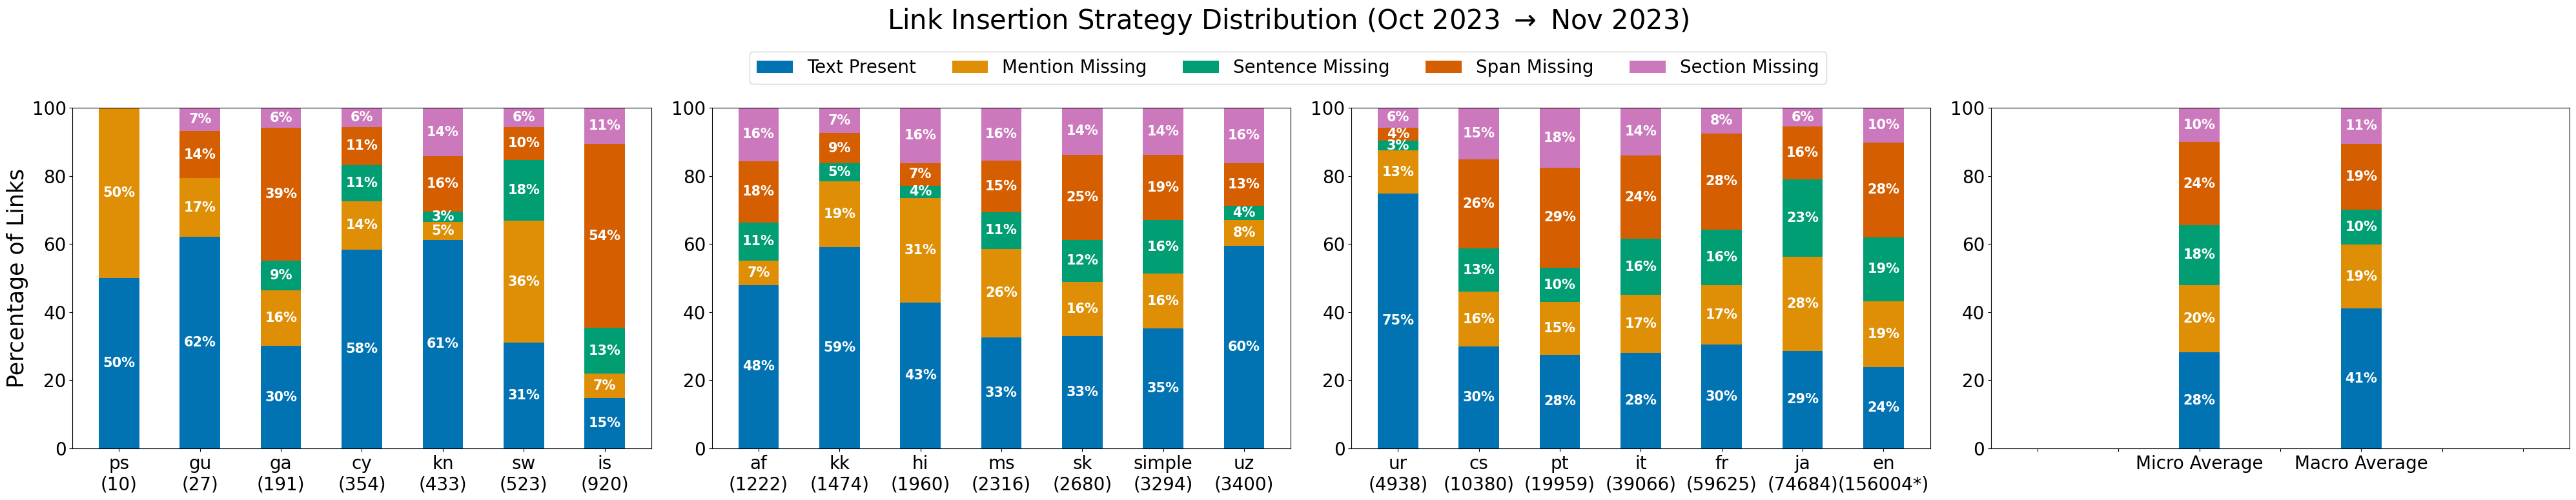

In [52]:
# matplotlib stacked bar plot
# create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(40, 7))

# set global title
fig.suptitle('Link Insertion Strategy Distribution (Oct 2023 $\\rightarrow$ Nov 2023)', fontsize=30, y=1.1)
# set y label for all subplots
for ax in axs:
    # ax.set_xlabel('Language', fontsize=20)
    ax.set_ylim(0, 100)
    ax.tick_params(axis='y', which='major', labelsize=20)
    # set to bold
    ax.tick_params(axis='x', which='major', labelsize=15)
axs[0].set_ylabel('Percentage of Links', fontsize=25)
languages = {k: v for k, v in sorted(languages.items(), key=lambda item: item[1]['total_clean'], reverse=False)}
labels = [f"{language}\n({languages[language]['total_clean_eval']})" if language != 'en' else \
        f"{language}\n({languages[language]['total_clean_eval']}*)" for language in languages]
labels.append('Micro Average')
labels.append('Macro Average')
labels = [labels[0:7], labels[7:14], labels[14:21], ['', '', labels[21], '', labels[22], '', '']]
for i, ax in enumerate(axs):
    ax.set_xticks(np.arange(len(labels[i])))
    ax.set_xticklabels(labels[i], rotation=0, fontsize=20)

present_text = []
missing_mention = []
missing_sentence = []
missing_span = []
missing_section = []

total = {'present_text': 0,
         'missing_mention': 0,
         'missing_sentence': 0,
         'missing_span': 0,
         'missing_section': 0,
         'total': 0}
for language in languages:
    present_text.append(languages[language]['present_text'])
    missing_mention.append(languages[language]['missing_mention'])
    missing_sentence.append(languages[language]['missing_sentence'])
    missing_span.append(languages[language]['missing_span'])
    missing_section.append(languages[language]['missing_section'])
    total['present_text'] += languages[language]['present_text'] * languages[language]['total_clean'] / 100
    total['missing_mention'] += languages[language]['missing_mention'] * languages[language]['total_clean'] / 100
    total['missing_sentence'] += languages[language]['missing_sentence'] * languages[language]['total_clean'] / 100
    total['missing_span'] += languages[language]['missing_span'] * languages[language]['total_clean'] / 100
    total['missing_section'] += languages[language]['missing_section'] * languages[language]['total_clean'] / 100
    total['total'] += languages[language]['total_clean']

# append micro average results
present_text.append(total['present_text'] / total['total'] * 100)
missing_mention.append(total['missing_mention'] / total['total'] * 100)
missing_sentence.append(total['missing_sentence'] / total['total'] * 100)
missing_span.append(total['missing_span'] / total['total'] * 100)
missing_section.append(total['missing_section'] / total['total'] * 100)
# append macro average results
present_text.append(sum(present_text[:-1]) / len(present_text[:-1]))
missing_mention.append(sum(missing_mention[:-1]) / len(missing_mention[:-1]))
missing_sentence.append(sum(missing_sentence[:-1]) / len(missing_sentence[:-1]))
missing_span.append(sum(missing_span[:-1]) / len(missing_span[:-1]))
missing_section.append(sum(missing_section[:-1]) / len(missing_section[:-1]))

# split into 4 subplots
present_text = [present_text[0:7], present_text[7:14], present_text[14:21], [0, 0, present_text[21], 0, present_text[22], 0, 0]]
missing_mention = [missing_mention[0:7], missing_mention[7:14], missing_mention[14:21], [0, 0, missing_mention[21], 0, missing_mention[22], 0, 0]]
missing_sentence = [missing_sentence[0:7], missing_sentence[7:14], missing_sentence[14:21], [0, 0, missing_sentence[21], 0, missing_sentence[22], 0, 0]]
missing_span = [missing_span[0:7], missing_span[7:14], missing_span[14:21], [0, 0, missing_span[21], 0, missing_span[22], 0, 0]]
missing_section = [missing_section[0:7], missing_section[7:14], missing_section[14:21], [0, 0, missing_section[21], 0, missing_section[22], 0, 0]]

bottom = [np.zeros(len(p)) for p in present_text]
present_text = [np.array(p) for p in present_text]
missing_mention = [np.array(p) for p in missing_mention]
missing_sentence = [np.array(p) for p in missing_sentence]
missing_span = [np.array(p) for p in missing_span]
missing_section = [np.array(p) for p in missing_section]

# use a colorblind friendly palette
for i, ax in enumerate(axs):
    ax.bar(np.arange(len(present_text[i])), present_text[i], label='Text Present', bottom=bottom[i], width=0.5, color=sns.color_palette('colorblind')[0])
    bottom[i] += present_text[i]
    ax.bar(np.arange(len(present_text[i])), missing_mention[i], label='Mention Missing', bottom=bottom[i], width=0.5, color=sns.color_palette('colorblind')[1])
    bottom[i] += missing_mention[i]
    ax.bar(np.arange(len(present_text[i])), missing_sentence[i], label='Sentence Missing', bottom=bottom[i], width=0.5, color=sns.color_palette('colorblind')[2])
    bottom[i] += missing_sentence[i]
    ax.bar(np.arange(len(present_text[i])), missing_span[i], label='Span Missing', bottom=bottom[i], width=0.5, color=sns.color_palette('colorblind')[3])
    bottom[i] += missing_span[i]
    ax.bar(np.arange(len(present_text[i])), missing_section[i], label='Section Missing', bottom=bottom[i], width=0.5, color=sns.color_palette('colorblind')[4])
    bottom[i] += missing_section[i]

# add legend to figure
# only show the legend for the first subplot
# make the legend horizontal and centered
# axs[0].legend(bbox_to_anchor=(2, 1.1), ncol=5, fontsize=20)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 1.02))
# reverse the order of the legend
# handles, labels = axs[0].get_legend_handles_labels()
# axs[0].legend(handles[::-1], labels[::-1],bbox_to_anchor=(1, 1.07), ncol=5, fontsize=18)


# add labels inside each bar
for row in range(len(axs)):
    for i, v in enumerate(present_text[row]):
        if v > 0:
            axs[row].text(i, v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=15)
    for i, v in enumerate(missing_mention[row]):
        if v > 0:
            axs[row].text(i, present_text[row][i]+v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=15)
    for i, v in enumerate(missing_sentence[row]):
        if v > 0:
            axs[row].text(i, present_text[row][i]+missing_mention[row][i]+v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=15)
    for i, v in enumerate(missing_span[row]):
        if v > 0:
            axs[row].text(i, present_text[row][i]+missing_mention[row][i]+missing_sentence[row][i]+v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=15)
    for i, v in enumerate(missing_section[row]):
        if v > 0:
            axs[row].text(i, present_text[row][i]+missing_mention[row][i]+missing_sentence[row][i]+missing_span[row][i]+v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=15)
plt.tight_layout()
plt.show()

<BarContainer object of 21 artists>

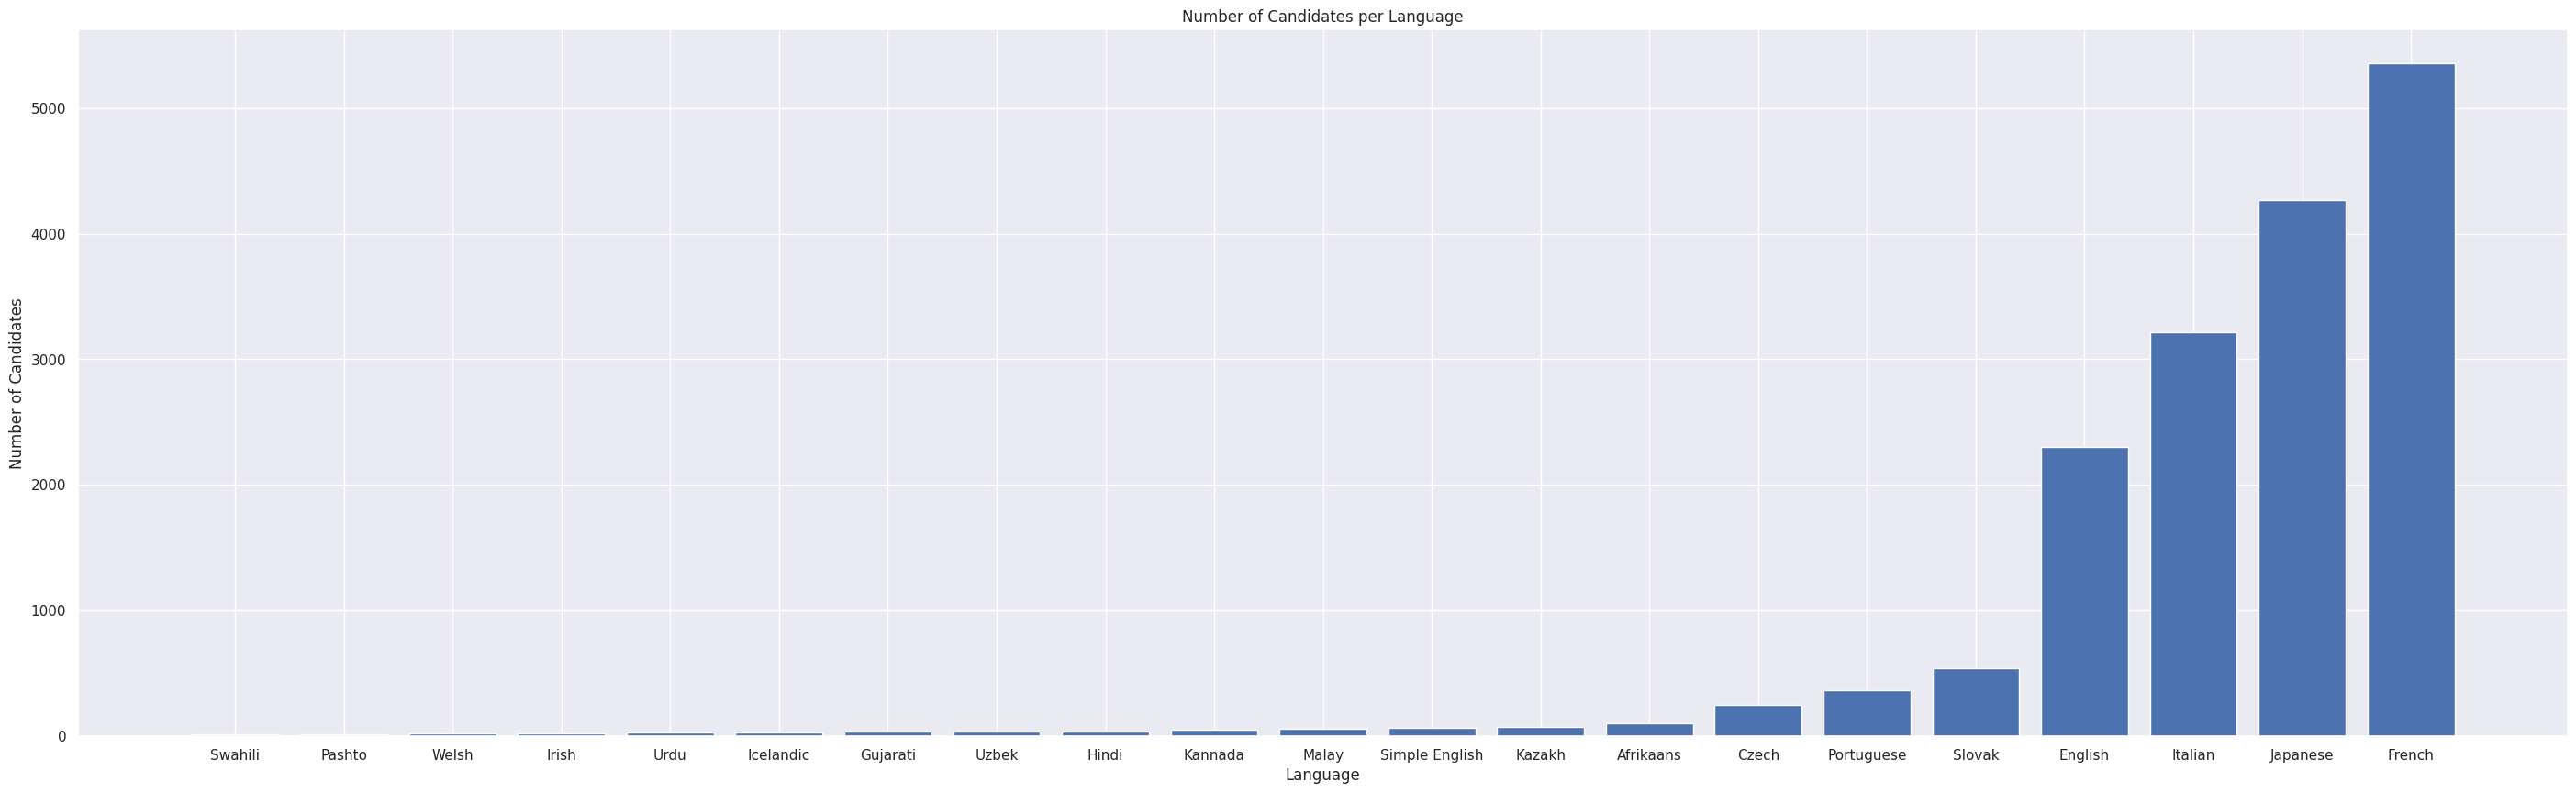

In [32]:
# plot a bar chart of the number of negative contexts per language
fig, ax = plt.subplots(figsize=(35, 10))
ax.set_title('Number of Candidates per Language')
ax.set_ylabel('Number of Candidates')
ax.set_xlabel('Language')
# sort the languages by number of candidates
languages = {k: v for k, v in sorted(languages.items(), key=lambda item: item[1]['candidates'])}
ax.set_xticks(np.arange(len(languages)))
ax.set_xticklabels([languages[language]['full'] for language in languages], rotation=0)
ax.bar(np.arange(len(languages)), [languages[language]['candidates'] for language in languages])


# Analyze processing failures

In [ ]:
import urllib
def process_title(title):
    return urllib.parse.unquote(title).replace('_', ' ')

def update_targets(target_name, redirect_map):
    counter = 0
    while target_name in redirect_map:
        target_name = redirect_map[target_name]
        counter += 1
        if counter > 10:
            break
    return target_name

In [ ]:
df_1 = pd.concat([pd.read_parquet(f'/scratch/tsoares/wikidumps/simplewiki-NS0-20231001/processed_data/good_links_{i}.parquet') for i in range(2)]).reset_index(drop=True)
df_2 = pd.concat([pd.read_parquet(f'/scratch/tsoares/wikidumps/simplewiki-NS0-20231101/processed_data/good_links_{i}.parquet') for i in range(2)]).reset_index(drop=True)
# df_pages_1 = pd.concat([pd.read_parquet(f'/scratch/tsoares/wikidumps/simplewiki-NS0-20231001/processed_data/good_pages_{i}.parquet') for i in range(2)]).reset_index(drop=True)

In [ ]:
redirect_map = pd.concat([pd.read_parquet(f'/scratch/tsoares/wikidumps/simplewiki-NS0-2023{month}01/processed_data/redirect_map.parquet') for month in [10, 11]]).reset_index(drop=True)
redirect_map = redirect_map['redirect'].to_dict()

df_1['target_title'] = df_1['target_title'].apply(
    lambda x: update_targets(x, redirect_map))
df_2['target_title'] = df_2['target_title'].apply(
    lambda x: update_targets(x, redirect_map))

df_1 = df_1[['source_title', 'target_title',
                'source_ID', 'target_ID', 'source_version']]
df_2 = df_2[['source_title', 'target_title',
                'source_ID', 'target_ID', 'source_version']]

# group the links by source and target and count the number of links
df_1 = df_1.groupby(['source_title', 'target_title', 'source_ID',
                    'target_ID', 'source_version']).size().reset_index(name='count')
df_2 = df_2.groupby(['source_title', 'target_title', 'source_ID',
                    'target_ID', 'source_version']).size().reset_index(name='count')

# find all new links added in df_2. Consider two cases
# 1. The row is not present in df_1
# 2. The row is present in df_1 but the count is smaller in df_1
df_diff = df_2.merge(df_1, how='left', on=[
                    'source_title', 'target_title', 'source_ID', 'target_ID'], suffixes=('_2', '_1'))
df_diff = df_diff[(df_diff['count_1'].isna()) | (df_diff['count_2'] > df_diff['count_1'])]
df_diff['count_1'] = df_diff['count_1'].fillna(0)
# df_diff['source_version_1'] = df_diff['source_version_1'].fillna('&oldid=0')
df_diff['count'] = df_diff['count_2'] - df_diff['count_1']
df_diff = df_diff[['source_title', 'target_title', 'source_ID',
                'target_ID', 'source_version_1', 'source_version_2', 'count']]


initial_size = df_diff['count'].sum()
print(f'Initially, there are {df_diff["count"].sum()} new candidate links, from {len(df_diff)} unique src-tgt pairs.')

Initially, there are 20152.0 new candidate links, from 18805 unique src-tgt pairs.


In [ ]:
df_diff

,source_title,target_title,source_ID,target_ID,source_version_1,source_version_2,count
367,%C2%A1Mucha_Lucha%21%3A_Gigante,Sweden,566381,2136,NaN,https://simple.wikipedia.org/w/index.php?title...,1.0
604,%C3%81lvaro_Noboa,President_of_Ecuador,633639,345075,https://simple.wikipedia.org/w/index.php?title...,https://simple.wikipedia.org/w/index.php?title...,1.0
714,%C3%81ngel_Mar%C3%ADa_Villar,Spaniards,682478,340635,NaN,https://simple.wikipedia.org/w/index.php?title...,1.0
952,%C3%84lghult,Sweden,480121,2136,NaN,https://simple.wikipedia.org/w/index.php?title...,1.0
958,%C3%84lmhult,Sweden,426745,2136,NaN,https://simple.wikipedia.org/w/index.php?title...,1.0
...,...,...,...,...,...,...,...
2288224,Zupee_%28Ludo%29,IIT,1054065,117041,NaN,https://simple.wikipedia.org/w/index.php?title...,1.0
2288225,Zupee_%28Ludo%29,Indian_Institutes_of_Technology,1054065,978515,NaN,https://simple.wikipedia.org/w/index.php?title...,1.0
2288226,Zupee_%28Ludo%29,Kapil_Sharma,1054065,841865,NaN,https://simple.wikipedia.org/w/index.php?title...,1.0
2288227,Zupee_%28Ludo%29,Ludo,1054065,966190,NaN,https://simple.wikipedia.org/w/index.php?title...,1.0


In [ ]:
df_diff['source_ID'] = df_diff['source_ID'].astype(int)

In [ ]:
# compare links in df with links in df_diff
# find links with source title in df_diff and not in df
df_diff['source_title'] = df_diff['source_title'].apply(process_title)
df['source_title'] = df['source_title'].apply(process_title)
df_diff_2 = df_diff.merge(df[['source_title', 'source_ID']].drop_duplicates(), how='left', on='source_title', suffixes=('_diff', '_df'))
df_diff_2 = df_diff_2[df_diff_2['source_ID_df'].isna()]
df_diff_2 = df_diff_2[['source_title', 'target_title', 'source_ID_diff', 'target_ID', 'source_version_1', 'source_version_2', 'count']]
df_diff_2['source_ID'] = df_diff_2['source_ID_diff']
df_diff_2 = df_diff_2.drop(columns=['source_ID_diff'])
df_diff_2 = df_diff_2.rename(columns={'source_ID': 'source_ID_diff'})
df_diff_2['source_ID_diff'] = df_diff_2['source_ID_diff'].astype(int)
# df_diff['source_version_1'] = df_diff['source_version_1'].apply(lambda x: x.replace('&oldid=', ''))
# df_diff['source_version_1'] = df_diff['source_version_1'].astype(int)
# df_diff['source_version_2'] = df_diff['source_version_2'].apply(lambda x: x.replace('&oldid=', ''))
# df_diff['source_version_2'] = df_diff['source_version_2'].astype(int)
df_diff_2['count'] = df_diff_2['count'].astype(int)
df_diff_2 = df_diff_2.sort_values(by=['source_ID_diff', 'target_ID', 'source_version_1', 'source_version_2']).reset_index(drop=True)
df_diff_2

NameError: name 'df' is not defined

In [ ]:
df_diff[df_diff['source_version_1'] != '&oldid=0']

In [ ]:
# compare links in df with links in df_diff
# find links with target title in df_diff and not in df
df_diff_3 = df_diff.merge(df[['target_title']].drop_duplicates(), how='left', on='target_title', suffixes=('_diff', '_df'))
df_diff_3 = df_diff_3[['source_title', 'target_title', 'source_ID', 'source_version_1', 'source_version_2', 'count']]
# df_diff['source_version_1'] = df_diff['source_version_1'].apply(lambda x: x.replace('&oldid=', ''))
# df_diff['source_version_1'] = df_diff['source_version_1'].astype(int)
# df_diff['source_version_2'] = df_diff['source_version_2'].apply(lambda x: x.replace('&oldid=', ''))
# df_diff['source_version_2'] = df_diff['source_version_2'].astype(int)
df_diff_3['count'] = df_diff_3['count'].astype(int)
df_diff_3 = df_diff_3.sort_values(by=['source_ID', 'source_version_1', 'source_version_2']).reset_index(drop=True)
df_diff_3

In [ ]:
df_diff_3[df_diff_3['source_version_1'] != '&oldid=0']

In [ ]:
# compare links in df with links in df_diff
# find links with target title and source title in df_diff and not in df
df_diff_4 = df_diff.merge(df[['source_title', 'target_title', 'source_ID']].drop_duplicates(), how='left', on=['source_title', 'target_title'], suffixes=('_diff', '_df'))
df_diff_4 = df_diff_4[df_diff_4['source_ID_df'].isna()]
df_diff_4 = df_diff_4[['source_title', 'target_title', 'source_ID_diff', 'target_ID', 'source_version_1', 'source_version_2', 'count']]
df_diff_4['source_ID'] = df_diff_4['source_ID_diff']
df_diff_4 = df_diff_4.drop(columns=['source_ID_diff'])
df_diff_4 = df_diff_4.rename(columns={'source_ID': 'source_ID_diff'})
df_diff_4['source_ID_diff'] = df_diff_4['source_ID_diff'].astype(int)
# df_diff['source_version_1'] = df_diff['source_version_1'].apply(lambda x: x.replace('&oldid=', ''))
# df_diff['source_version_1'] = df_diff['source_version_1'].astype(int)
# df_diff['source_version_2'] = df_diff['source_version_2'].apply(lambda x: x.replace('&oldid=', ''))
# df_diff['source_version_2'] = df_diff['source_version_2'].astype(int)
df_diff_4['count'] = df_diff_4['count'].astype(int)
df_diff_4 = df_diff_4.sort_values(by=['source_ID_diff', 'target_ID', 'source_version_1', 'source_version_2']).reset_index(drop=True)
df_diff_4

In [ ]:
df_diff_4[df_diff_4['source_version_1'] != '&oldid=0']

In [ ]:
df_diff.sample(10)

In [ ]:
df

In [ ]:
df[df['source_title'] == 'Acanthopterygii']

In [ ]:
df_diff[df_diff['source_title'] == 'Acanthopterygii']

In [ ]:
df_versions = pd.read_parquet('/scratch/tsoares/wikidumps/simplewiki-NS0-20231001/eval/link_versions.parquet')
df_versions

In [ ]:
df_versions[df_versions['source_title'] == 'Acanthopterygii']

In [ ]:
#print df_diff sorted by source_ID
# df_diff[df_diff['source_version_1']  != '&oldid=0'].sort_values(by=['source_ID']).reset_index(drop=True)
df_diff.sort_values(by=['source_ID']).reset_index(drop=True)